# Simulation of Lennard-Jones Fluid #

This example will simulate a simple liquid that interacts *via* the Lennard-Jones pair potential:

$$
    u(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

The Lennard-Jones potential has two parameters: the energy $\varepsilon$ and the size $\sigma$.

First, we import `relentless`. We don't need to import any simulation packages because `relentless` will take care of this for us.

In [1]:
import relentless

## Model

Next, we setup the model. We will assign the type 1 to the particles. We create an instance `lj` of the Lennard-Jones potential. Then, we specify the parameters for interactions between particles of type 1 by updating the pairwise matrix `lj.coeff`:

In [2]:
lj = relentless.model.potential.LennardJones(types=("1",))
lj.coeff["1", "1"].update({
    "epsilon": 1.0, "sigma": 1.0, "rmax": 3.0, "shift": True
})

Here, we have chosen $\varepsilon = 1$ and $\sigma = 1$. We have also used `rmax` and `shift` options to truncate the potential to zero at $3\sigma$, which is a common choice for the Lennard-Jones potential.

To finish specifying the model, we should also define the thermodynamic state, e.g., the number of particles, the volume, and the temperature. We can conveniently collect this data in an `Ensemble`:

In [3]:
state = relentless.model.Ensemble(
    T=1.5, V=relentless.model.extent.Cube(L=10.0), N={"1": 400}
)

Here, we have chosen to run the simulation of $N=100$ particles in a cubic box with edge length $L=10$ at temperature $T=1.5$. The units of $L$ are implicit to the model (i.e., they are *same* as $\sigma$). The units of $T$ are also partially implicit to the model (i.e., they are *related* to the units of $\varepsilon$) but can be manipulated through the Boltzmann constant $k_{\rm B}$ that converts between energy and temperature units. By default, $k_{\rm B} = 1$.

## Simulation

We now need to specify our simulation protocol. `relentless` runs a simulation as a sequence of operations.

Every simulation protocol **must** have an initialization operation to set up the system. Here, we will initialize our system in a semi-random configuration. The `diameters` option spaces out the particles so prevent overlap.

In [4]:
init = relentless.simulate.InitializeRandomly(
    seed=42, T=state.T, V=state.V, N=state.N, diameters={"1": 1}
)

After initialization, we can run a sequence of simulation steps. Our first simulation step is a short equilibration using Langevin dynamics:

In [5]:
eq = relentless.simulate.RunLangevinDynamics(
    steps=10000, timestep=0.005, T=1, friction=0.1, seed=2
)

Then, we will run a production simulation using Langevin dynamics. We attach an analysis operation to this step so that we can also write a trajectory `filename.gsd` of the particles:

In [6]:
dump = relentless.simulate.WriteTrajectory(
    filename="trajectory.gsd", every=2000
)

prod = relentless.simulate.RunLangevinDynamics(
    steps=50000, timestep=0.005, T=1, friction=0.1, seed=7, analyzers=dump
)

Now that we have setup all of our operations, we can combine them together to be run by a particular simulation engine. Here we will use HOOMD-blue to perform the simulation.

In order to run this cell, you need to make sure you have `hoomd` and its dependencies like `freud` installed, or you will get an error.

In [7]:
sim = relentless.simulate.HOOMD(initializer=init, operations=[eq, prod])

Now we are almost ready to run the simulation!

We need to prepare the model's potentials for the run using `relentless.simulate.Potentials`. This object will turn one or more potentials, which are analytical functions in `relentless`, into a single *tabulated* potential that can be simulated. This means that you need to specify a few additional parameters for the tabulated potential (its starting point, stopping point, and number of subdivisions), along with the buffer that is used to construct pair neighbor lists in many simulation packages.

 Note: The starting point should be greater than zero, and the stopping point should sized based on where you would typically truncate interactions. These values must be fixed numbers so if you plan to vary any potential parameters, make sure that you either choose them to be enough or also rememnber to update them.

In [8]:
pot = relentless.simulate.Potentials(lj)
pot.pair.start = 1e-6
pot.pair.stop = 3.0
pot.pair.num = 100
pot.pair.neighbor_buffer = 0.5

Last, we can run the simulation. An output directory is required for all runs, so here we will use the working directory.

This will be the slowest step of this example, but don't worry, it took less than a minute to run on an old laptop.

In [9]:
result = sim.run(potentials=pot, directory=".")

The `result` contains data from the run. Some of it can be useful for subsequent analysis, but some of it is just used internally by `relentless`.

## Analysis

To demonstrate that the simulation ran, we perform additional analysis of the trajectory file that was created. We will use the `gsd` package to read the file and the `freud` package to compute the radial distribution function $g(r)$. You need to make sure you have both installed.

Note that we use `result.directory` (which is a `relentless.data.Directory`) to get the path to `trajectory.gsd` created by the simulation!

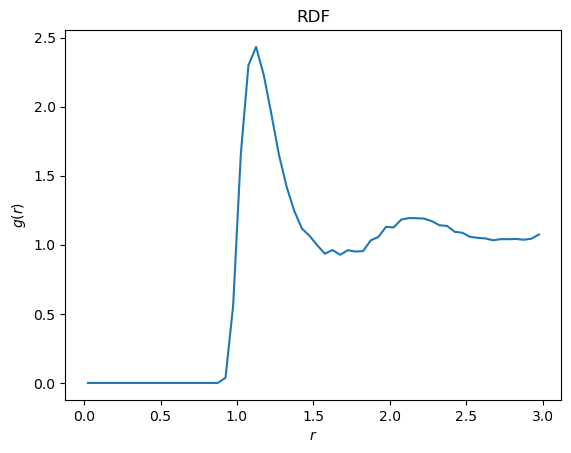

In [13]:
import freud
import gsd.hoomd

rdf = freud.density.RDF(bins=60, r_max=3.0)
with gsd.hoomd.open(result.directory.file("trajectory.gsd")) as traj:
    for snap in traj:
        rdf.compute(snap, reset=False)
rdf.plot();

This looks like a typical correlation function for a liquid!